In [1]:
import sys
sys.path.append('A:\MSBGD\Data_Challenge')
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from source.evaluator import gap_eval_scores
from source.preprocessing import pca_norm,balance_data

with open('../data/data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)

In [2]:
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

In [3]:
X.shape

(27749, 768)

In [4]:
X_res, Y_res, S_res = balance_data(X, Y, S)
X_pca = pca_norm(X_res, n_components=0.95)
# save preprocessed data
#with open('../data/preprocessed_data.pickle', 'wb') as handle:
#    pickle.dump({'X': X_pca, 'Y': Y_res, 'S': S_res}, handle, protocol=pickle.HIGHEST_PROTOCOL)
#    print('Preprocessed data saved')


In [5]:
print(X_pca.shape)

(231980, 284)


In [6]:
# number of classes
print("Y unique :",Y_res.unique().shape[0])
print("Y value counts :",Y_res.value_counts())

Y unique : 28
Y value counts : profession_class
6     8285
9     8285
8     8285
17    8285
16    8285
0     8285
23    8285
4     8285
3     8285
24    8285
14    8285
5     8285
27    8285
7     8285
20    8285
15    8285
25    8285
11    8285
12    8285
26    8285
1     8285
2     8285
13    8285
18    8285
19    8285
21    8285
22    8285
10    8285
Name: count, dtype: int64


In [10]:
print("X head :",X_pca)
print("Y head :",Y_res)
print("S head :",S_res)

X head : [[-4.2760324   0.9520488   0.81553245 ...  0.06925003  0.05235701
   0.16938135]
 [ 5.059198   -1.9878947  -3.533995   ...  0.27128112  0.6655656
   0.42626575]
 [-5.095928    4.6491036  11.0897455  ...  0.18813397 -0.19583689
   0.16991548]
 ...
 [ 5.929963   -7.80592     3.0991042  ...  0.09112659  0.02528825
  -0.34227192]
 [ 6.619555   -2.2321649   6.248621   ...  0.02681849  0.08390919
  -0.21164598]
 [ 8.80605    -4.264424    4.8725777  ... -0.3381093   0.3561081
  -0.10610942]]
Y head : 0          6
1          9
2          6
3         22
4         21
          ..
231975    27
231976    27
231977    27
231978    27
231979    27
Name: profession_class, Length: 231980, dtype: int64
S head : 0         0
1         1
2         0
3         1
4         0
         ..
231975    1
231976    1
231977    1
231978    1
231979    1
Name: S, Length: 231980, dtype: int64


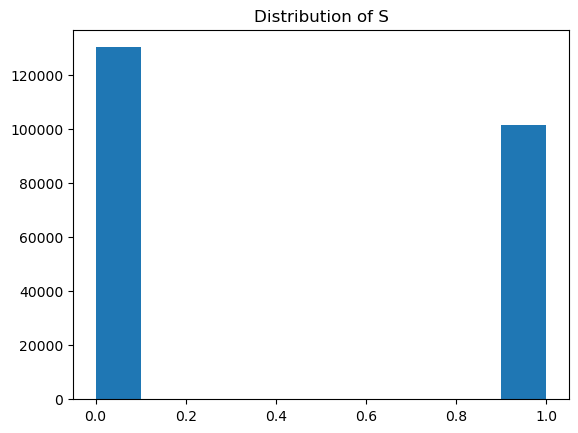

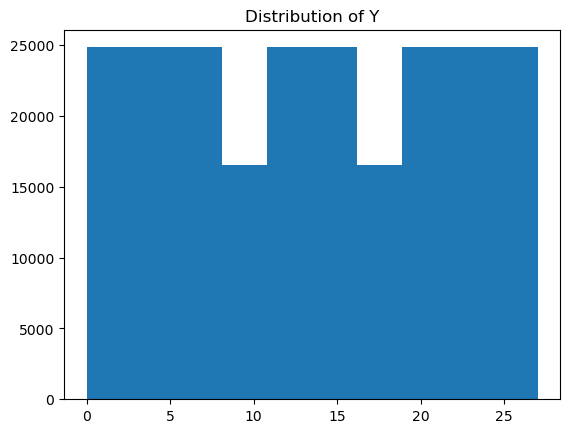

In [13]:
# visualize distribution of data
plt.hist(S_res)
plt.title('Distribution of S')
plt.show()

# visualize distribution of data
plt.hist(Y_res)
plt.title('Distribution of Y')
plt.show()

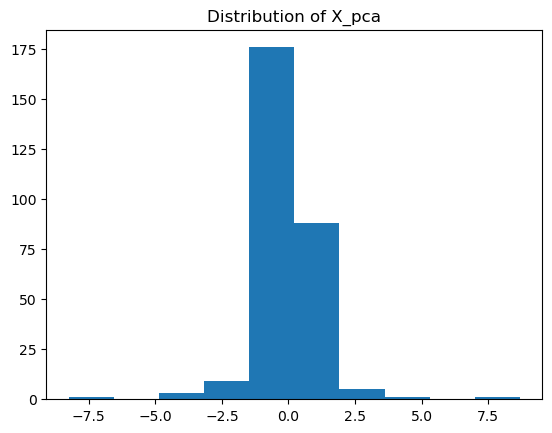

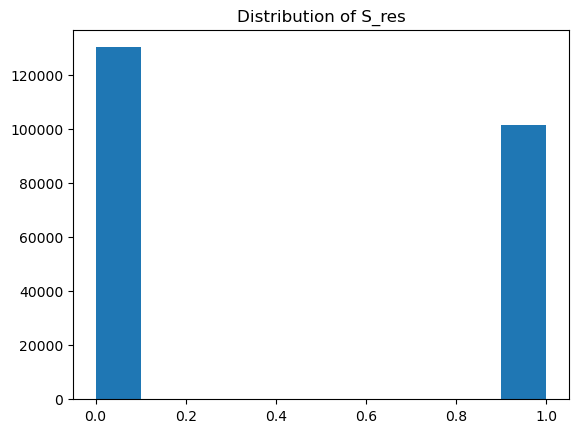

In [15]:
plt.hist(X_pca[0,:])
plt.title('Distribution of X_pca')
plt.show()

plt.hist(S_res)
plt.title('Distribution of S_res')
plt.show()


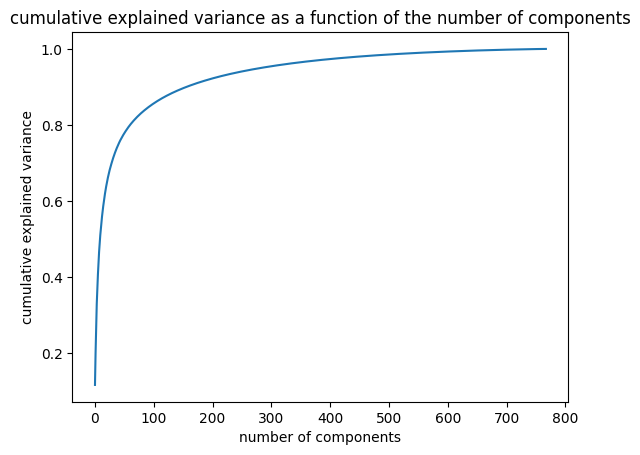

In [ ]:
# Feature selection with pca
pca = PCA()
pca.fit(X_res)
# cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(cumulative_explained_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('cumulative explained variance as a function of the number of components')
plt.show()

In [ ]:
# hose components that explain 95% of the variance
pca = PCA(n_components=0.95)
pca.fit(X_res)
X_pca = pca.transform(X_res)
print("X_pca shape :",X_pca.shape)
# split data into train and test
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X_pca, Y_res, S_res, test_size=0.3, random_state=42)
# convert all to numpy array
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
Y_train = torch.from_numpy(Y_train)
Y_test = torch.from_numpy(Y_test)


In [14]:
print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)
print("Y_train shape :",Y_train.shape)
print("Y_test shape :",Y_test.shape)

X_train shape : torch.Size([162386, 284])
X_test shape : torch.Size([69594, 284])
Y_train shape : torch.Size([162386])
Y_test shape : torch.Size([69594])


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(284, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 28),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.MLP(x)
        return logits

loss_fn = nn.CrossEntropyLoss()

# Create an instance of the neural network
model = NeuralNetwork().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
def train(model, optimizer, loss_fn, inputs, labels, n_epochs):
    model.train()
    inputs = inputs.to(device)
    labels = labels.to(device)

    for epoch in range(n_epochs):
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Example usage
inputs = X_train.to(device)
labels = Y_train.to(device)
n_epochs = 3300
train(model, optimizer, loss_fn, inputs, labels, n_epochs)


Epoch 0, Loss: 3.3322277069091797
Epoch 1, Loss: 3.330561399459839
Epoch 2, Loss: 3.3263821601867676
Epoch 3, Loss: 3.314913272857666
Epoch 4, Loss: 3.2833242416381836
Epoch 5, Loss: 3.246073007583618
Epoch 6, Loss: 3.1955370903015137
Epoch 7, Loss: 3.144015312194824
Epoch 8, Loss: 3.0844504833221436
Epoch 9, Loss: 3.0185036659240723
Epoch 10, Loss: 2.961442708969116
Epoch 11, Loss: 2.908762216567993
Epoch 12, Loss: 2.8659353256225586
Epoch 13, Loss: 2.8132948875427246
Epoch 14, Loss: 2.7952988147735596
Epoch 15, Loss: 2.752304792404175
Epoch 16, Loss: 2.734588384628296
Epoch 17, Loss: 2.7071330547332764
Epoch 18, Loss: 2.6855907440185547
Epoch 19, Loss: 2.680046558380127
Epoch 20, Loss: 2.6631853580474854
Epoch 21, Loss: 2.655107259750366
Epoch 22, Loss: 2.6472153663635254
Epoch 23, Loss: 2.6410930156707764
Epoch 24, Loss: 2.635834217071533
Epoch 25, Loss: 2.629591226577759
Epoch 26, Loss: 2.625103235244751
Epoch 27, Loss: 2.6227428913116455
Epoch 28, Loss: 2.618642568588257
Epoch 29,

In [21]:
# Test the model
def evaluate(model, inputs, labels):
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)
    _, Y_pred = torch.max(outputs, 1)
    Y_pred = Y_pred.cpu().numpy()
    # Compute the accuracy
    eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
    final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
    print(final_score)
    return eval_scores, confusion_matrices_eval

inputs = X_test.to(device)
labels = Y_test.to(device)
evaluate(model, inputs, labels)

ValueError: Found input variables with inconsistent numbers of samples: [69594, 11893]

In [20]:
# Load the "true" test data
X_test = dat['X_test']
S_test = dat['S_test'] 
# Classify the provided test data with you classifier
X_test = pca.transform(X_test)
X_test = torch.tensor(X_test)
inputs = X_test.to(device)
outputs = model(inputs)
_, y_test = torch.max(outputs, 1)
y_test = y_test.cpu().numpy()
results=pd.DataFrame(y_test, columns= ['score'])

results.to_csv("Data_Challenge_MDI_341.csv", header = None, index = None)
# np.savetxt('y_test_challenge_student.txt', y_test, delimiter=',')

/home/aleksander/.local/share/virtualenvs/Data_Challenge-2KO3xTh2/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/aleksander/.local/share/virtualenvs/Data_Challenge-2KO3xTh2/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
